In [1]:
import pandas as pd
import numpy as np
from gravity_utils import *

In [2]:
pd.set_option('display.max_rows', 1398)

In [3]:
import shapefile
import shapely.wkt

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats
import stat
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, log_loss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso

In [5]:
def print_stats (model, X, y):
    lm = model
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    # newX = pd.DataFrame({"Constant":np.ones(len(X))}, index = X.index).join(pd.DataFrame(X))
    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    # Note if you don't want to use a DataFrame replace the two lines above with
    # newX = np.append(np.ones((len(X),1)), X, axis=1)
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
    myDF3.index = np.append(['intercept_'], X.columns.values)
    print(myDF3)

In [6]:
sams_w_nbuildings = pd.read_csv('data/GIS/B1_samsSW_20131231_shp/B1_sams_with_nbuildings.csv', sep=';', index_col=0)
sams_w_nbuildings['SAMSCODE'] = sams_w_nbuildings.SAMSCODE.astype(int)
sams_w_nbuildings['KOMMUN'] = sams_w_nbuildings.KOMMUN.astype(int)

In [7]:
resfil_raw = pd.read_csv('data/rvu/RVU_resfil.csv')
upsampled_resfil = draw_population(resfil_raw, resfil_raw.individvikt.astype(int))
upsampled_resfil = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1)] 
#                                     (upsampled_resfil['rf4_komkod'] < 2000) &
#                                     (upsampled_resfil['rf4_komkod'] > 100) &
#                                     (upsampled_resfil['rf1_komkod'] < 2000) &
#                                     (upsampled_resfil['rf1_komkod'] > 100)
#                                    ]
attraction_rvu = upsampled_resfil[(upsampled_resfil['rf4_komkod'] < 2000) &
                                    (upsampled_resfil['rf4_komkod'] > 100)].groupby('rf4_komkod')['Id'].count()
production_rvu = upsampled_resfil[(upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

production_rvu_sams = upsampled_resfil[(upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()

In [8]:
production_raw_rvu = resfil_raw[(resfil_raw['ärende_2'] == 1) &
                                (resfil_raw['rf1_komkod'] < 2000) &
                                (resfil_raw['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()

rvu_vs_scb = pd.DataFrame([production_raw_rvu, 
                           sams_w_nbuildings.set_index('SAMSCODE').TotBef, 
                           production_raw_rvu / sams_w_nbuildings.set_index('SAMSCODE').TotBef,
                           production_rvu_sams
                          ], 
             index=['rvu', 'sams', 'ratio', 'upsampled_rvu']).T.sort_values(['ratio'], ascending=False)

In [9]:
sams_ids = rvu_vs_scb[(rvu_vs_scb['ratio'] < 10) & (rvu_vs_scb['ratio'] > 0.03) & (rvu_vs_scb['rvu'] > 5)]
sams_index = sams_ids.index
sams_ids

,rvu,sams,ratio,upsampled_rvu
12810036.0,8.0,3.0,2.666667,326.0
12810083.0,33.0,563.0,0.058615,143.0
12620018.0,13.0,238.0,0.054622,135.0
12810019.0,31.0,582.0,0.053265,1361.0
12840025.0,99.0,1872.0,0.052885,644.0
12840031.0,98.0,1926.0,0.050883,435.0
12620019.0,6.0,122.0,0.049180,42.0
12850030.0,18.0,384.0,0.046875,148.0
12620020.0,19.0,442.0,0.042986,139.0
12810109.0,6.0,142.0,0.042254,96.0


In [10]:
a2 = read_shapefile('data/GIS/A2_samsSW_2012_shp/A2_sw_region.shp')
a2['KOMMUN'] = a2.KOMMUN.astype(int)
a2['SAMSCODE'] = a2.SAMSCODE.astype(int)
night_pop = a2[(a2.KOMMUN > 1200) & (a2.KOMMUN < 1300)]
# target_night_pop = night_pop.loc[(night_pop.KOMMUN == 1265) | (night_pop.KOMMUN == 1270)]
target_night_pop = night_pop.set_index('SAMSCODE').reset_index()
target_night_pop = target_night_pop.groupby(['SAMSCODE'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
target_night_pop.columns=[u'TotaltA2', u'OffentligaA2', u'NaringslivA2']
# other_night_pop = night_pop.loc[(night_pop.KOMMUN != 1265) & (night_pop.KOMMUN != 1270)]
other_night_pop = night_pop
other_night_pop = other_night_pop.groupby(['KOMMUN'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
other_night_pop.columns=[u'TotaltA2', u'OffentligaA2', u'NaringslivA2']

a4 = read_shapefile('data/GIS/A4_samsSW_2012_shp/A4_sw_region.shp')
a4['KOMMUN'] = a4.KOMMUN.astype(int)
a4['SAMSCODE'] = a4.SAMSCODE.astype(int)
a4 = a4[(a4.KOMMUN > 1200) & (a4.KOMMUN < 1300)]
target_day_pop = a4.set_index('SAMSCODE').reset_index()
# target_day_pop = a4.loc[(a4.KOMMUN == 1265) | (a4.KOMMUN == 1270)]
target_day_pop = target_day_pop.groupby(['SAMSCODE'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
target_day_pop.columns=[u'TotaltA4', u'OffentligaA4', u'NaringslivA4']
other_day_pop = a4
# other_day_pop = a4.loc[(a4.KOMMUN != 1265) & (a4.KOMMUN != 1270)]
other_day_pop = other_day_pop.groupby(['KOMMUN'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
other_day_pop.columns=[u'TotaltA4', u'OffentligaA4', u'NaringslivA4']

# target_buildings = sams_w_nbuildings.loc[(sams_w_nbuildings.KOMMUN == 1265) | (sams_w_nbuildings.KOMMUN == 1270)]
target_buildings = sams_w_nbuildings.set_index('SAMSCODE').reset_index()
target_buildings = target_buildings.groupby(['SAMSCODE']).sum()
# other_buildings = sams_w_nbuildings.loc[(sams_w_nbuildings.KOMMUN != 1265) & (sams_w_nbuildings.KOMMUN != 1270)]
other_buildings = sams_w_nbuildings
other_buildings = other_buildings.groupby(['KOMMUN']).sum()

#buildings = sams_w_nbuildings.groupby(['SAMSCODE'])['nProduction', 'nAttraction','TotBef', 'small_building', 'appt_build', 'multi_appartment_building'].sum()

In [11]:
production_sams_rvu = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1) &
                                    (upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
production_kommun_rvu = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1) &
                                    (upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

In [12]:
target_x_sams = pd.concat([target_night_pop, target_buildings, target_day_pop], axis=1).sort_index()
other_x_sams = pd.concat([other_night_pop, other_buildings, other_day_pop], axis=1).sort_index()

all_x_sams = pd.concat([target_x_sams, other_x_sams]).sort_index()

# all_y_prod = pd.concat([target_night_pop, other_night_pop])
# all_y_att = pd.concat([target_day_pop, other_day_pop])

kommun_rvu_prod = production_kommun_rvu.sort_index()
sams_rvu_prod = production_sams_rvu.sort_index()

all_y_prod = pd.concat([kommun_rvu_prod, sams_rvu_prod]).sort_index()

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


[Text(0, 0.5, 'RVU trips / SCB night population'),
 Text(0.5, 0, 'SCB night population')]

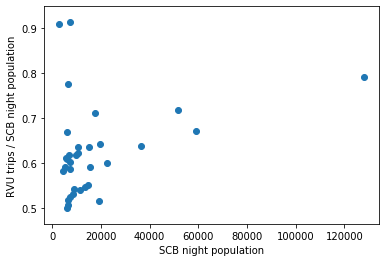

In [13]:
fig, ax = plt.subplots()
ax.scatter(other_night_pop.TotaltA2 ,production_kommun_rvu / other_night_pop.TotaltA2)
ax.set(xlabel='SCB night population', ylabel='RVU trips / SCB night population')

[Text(0, 0.5, 'RVU trips'), Text(0.5, 0, 'SCB night population')]

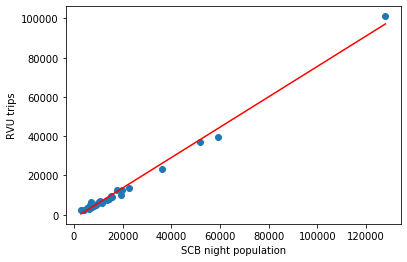

In [14]:
fig, ax = plt.subplots()
xp = other_night_pop.TotaltA2
yp = production_kommun_rvu
ax.scatter(xp, yp)
ax.plot(np.unique(xp), np.poly1d(np.polyfit(xp, yp, 1))(np.unique(xp)), color='red')
ax.set(xlabel='SCB night population', ylabel='RVU trips',)

In [15]:
r_trips = pd.DataFrame(other_night_pop.sum()).join(pd.DataFrame([0,0,0], index=other_night_pop.sum().index, columns=[1])).T

In [16]:
lin = LinearRegression(fit_intercept=False, )

# x_trips = r_trips[['OffentligaA2','NaringslivA2']]
# y_trips = [production_kommun_rvu.sum(),0]
x_trips = other_night_pop[['OffentligaA2','NaringslivA2']]
y_trips = production_kommun_rvu

scaler_trip = StandardScaler(with_std=False, with_mean=False)
scaler_trip.fit(x_trips)

X_trips = pd.DataFrame(scaler_trip.transform(x_trips), columns=x_trips.columns, index=x_trips.index)
trip_model = lin.fit(X_trips, y_trips)
other_trip_pred = pd.DataFrame(trip_model.predict(X_trips), index=y_trips.index, columns=['trips'])
score = r2_score(y_trips, other_trip_pred)
print('R**2 value')
print(score)
# print(pd.DataFrame(production_model.coef_, index=X_prod.columns))
print_stats(trip_model, X_trips, y_trips)

R**2 value
0.9853849542286283
              Coefficients  Standard Errors  t values  Probabilites
intercept_          0.0000          498.054     0.000         1.000
OffentligaA2        0.8741            0.231     3.783         0.001
NaringslivA2        0.6798            0.098     6.908         0.000


In [17]:
pd.DataFrame(trip_model.predict(scaler_trip.transform(target_night_pop[['OffentligaA2','NaringslivA2']])), columns=['Predicted'], index=target_night_pop.index).join(sams_rvu_prod).join(target_night_pop.TotaltA2)

,Predicted,Id,TotaltA2
SAMSCODE,,,
12140001,55.548269,NaN,76
12140002,664.934108,437.0,893
12140003,299.400386,436.0,401
12140004,279.102253,220.0,378
12140005,99.151253,109.0,137
12140006,688.041875,668.0,939
12140007,59.917972,NaN,83
12140008,279.294493,184.0,384
12140009,541.011979,61.0,743


In [18]:
target_night_pop.TotaltA2
target_trip_pred = pd.DataFrame(trip_model.predict(scaler_trip.transform(target_night_pop[['OffentligaA2', 'NaringslivA2']])), index=target_night_pop.index, columns=['trips'])
score = r2_score(target_night_pop.TotaltA2, target_trip_pred)
print('R**2 value')
print(score)

R**2 value
0.8698658083946653


# Production linear regression

In [19]:
lin = Lasso(alpha=0.001,precompute=True,max_iter=10000, fit_intercept=False,
            positive=True, random_state=42, selection='random')

x_prod = other_x_sams.drop(axis=1, labels=['Ald20_24','TotBef','nIndustri','NaringslivA4','nEkonomi','OffentligaA4','TotaltA4','OffentligaA2','Ald65_W','Ald16_19','Ald7_15','Ald0_6','appt_build','multi_appartment_building','nProduction','nAttraction','NaringslivA2','TotaltA2','SAMSCODE'])
y_prod = other_trip_pred

# x_prod = other_x_sams.drop(axis=1, labels=['Ald20_24','TotBef','Ald65_W','Ald7_15','multi_appartment_building','nEkonomi','nIndustri','nProduction','appt_build','nAttraction','Ald16_19','Ald0_6','SAMSCODE', 'TotaltA2', 'OffentligaA2', 'NaringslivA2', 'TotaltA4', 'OffentligaA4', 'NaringslivA4'])
# y_prod = other_night_pop.TotaltA2

x_prod = x_prod.drop(labels=[1280,1281,1283,1290,1292, 1293])
y_prod = y_prod.drop(labels=[1280,1281,1283,1290,1292, 1293])

scaler_prod = StandardScaler(with_std=False, with_mean=False)
# scaler_att = Normalizer()
# scaler_att = MinMaxScaler()
scaler_prod.fit(x_prod)

X_prod = pd.DataFrame(scaler_prod.transform(x_prod), columns=x_prod.columns, index=x_prod.index)
production_model = lin.fit(X_prod, y_prod)
train_prod_pred = production_model.predict(X_prod)
score = r2_score(y_prod, train_prod_pred)
print('R**2 value')
print(score)
# print(pd.DataFrame(production_model.coef_, index=X_prod.columns))
print_stats(production_model, X_prod, y_prod.T)

R**2 value
0.9876768617948433
                Coefficients  Standard Errors  t values  Probabilites
intercept_            0.0000           20.737     0.000           1.0
Ald25_44              0.8501            0.017    50.607           0.0
Ald45_64              0.3008            0.021    14.477           0.0
small_building        0.1740            0.006    28.684           0.0


In [20]:
y_pred = production_model.predict(scaler_prod.transform(target_x_sams.loc[:, X_prod.columns]))
score = r2_score(y_pred, target_trip_pred)
print('R**2 value')
print(score)

R**2 value
0.9365983342858094


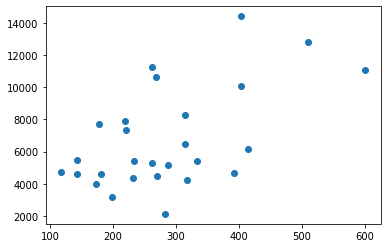

In [21]:
plt.scatter(other_x_sams.nIndustri.drop(labels=[1280,1281,1283,1290,1292, 1293]), y_prod)

In [22]:
pred_prod_sams = pd.DataFrame(y_pred, index=target_x_sams.index, columns=['pred_prod'])
df = pd.concat([pred_prod_sams, target_trip_pred], axis=1)
df['diff'] = df.pred_prod / df.trips
df.describe()

,pred_prod,trips,diff
count,1397.000000,1397.000000,1334.000000
mean,310.286088,297.481530,inf
std,341.641953,322.223193,NaN
min,0.000000,0.000000,0.000000
25%,70.888767,68.853078,0.914020
50%,205.271672,203.258619,0.993636
75%,432.675936,417.586367,1.115254
max,2792.342249,2630.478281,inf


ValueError: x and y must be the same size

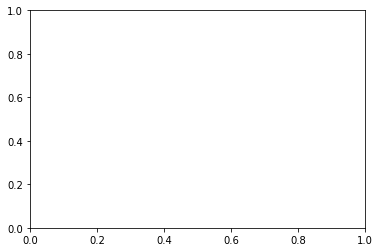

In [23]:
xp = (all_x_sams.nIndustri.drop(labels=[1280,1281,1283,1290,1292,1293]))
yp = all_y_prod.drop(labels=[1280,1281,1283,1290,1292,1293])
# xp = all_x_sams.small_building
# yp = all_y_att.TotaltA4

fig, ax = plt.subplots()

ax.scatter(xp, yp)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

ax.plot(np.unique(xp), np.poly1d(np.polyfit(xp, yp, 1))(np.unique(xp)), color='red')

ax.plot()

fig, ax = plt.subplots()
sns.set(style="whitegrid")

# Plot the residuals after fitting a linear model
sns.residplot(xp, yp, lowess=True, color="g")

# Attraction Linear regression

In [24]:
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.001,precompute=True,max_iter=10000, fit_intercept=False,
            positive=True, random_state=42, selection='random')

x_att = other_x_sams.drop(axis=1, labels=['TotBef','Ald20_24','appt_build','nEkonomi','small_building','nAttraction','Ald45_64','Ald25_44','multi_appartment_building','Ald16_19','nProduction','Ald7_15','Ald0_6','SAMSCODE', 'TotaltA2', 'OffentligaA2', 'NaringslivA2', 'TotaltA4', 'OffentligaA4', 'NaringslivA4'])
y_att = other_day_pop.TotaltA4

x_att = x_att.drop(labels=[1280,1281,1283,1290,1292, 1293])
y_att = y_att.drop(labels=[1280,1281,1283,1290,1292, 1293])

# x_att_s = x_att.append(pd.DataFrame(np.zeros(len(x_att.columns)), index=x_att.columns).T)
scaler_att = StandardScaler(with_std=False, with_mean=False)
# scaler_att = Normalizer()
# scaler_att = MinMaxScaler()
scaler_att.fit(x_att)

X_att = pd.DataFrame(scaler_att.transform(x_att), columns=x_att.columns, index=x_att.index)
attraction_model = lin.fit(X_att, y_att)
train_att_pred = attraction_model.predict(X_att)
score = r2_score(y_att, train_att_pred)
print('R**2 value')
print(score)
print_stats(attraction_model, X_att, y_att)

R**2 value
0.867905410790929
            Coefficients  Standard Errors  t values  Probabilites
intercept_        0.0000          585.337     0.000         1.000
Ald65_W           1.0507            0.128     8.186         0.000
nIndustri         5.7898            2.228     2.599         0.015


In [25]:
y_att_pred = attraction_model.predict(scaler_att.transform(target_x_sams.loc[:, x_att.columns]))
score = r2_score(y_att_pred, target_x_sams.TotaltA4)
print('R**2 value')
print(score)

R**2 value
-4.9851265049485685


In [26]:
pred_attr_sams = pd.DataFrame(y_att_pred, index=target_x_sams.index, columns=['pred_att'])
df = pd.concat([pred_attr_sams, target_day_pop.TotaltA4], axis=1)
df['diff'] = df.pred_att / df.TotaltA4

df.describe()

,pred_att,TotaltA4,diff
count,1397.000000,1397.000000,1385.000000
mean,239.166936,368.118826,inf
std,273.182367,729.731887,NaN
min,0.000000,0.000000,0.000000
25%,57.854708,53.000000,0.554233
50%,144.550970,150.000000,1.071336
75%,311.081549,375.000000,1.911745
max,1927.496678,9232.000000,inf


# Gravity model for SAMS

# Gravity

In [27]:
sams_distance_matrix = pd.read_csv('data/sams_distance_matrix_with_kommun.csv', sep=';', index_col=[0])
sams_distance_matrix.columns = sams_distance_matrix.index
#the thing above is differently sorted
sams_distance_matrix = sams_distance_matrix.sort_index().T.sort_index().T

In [28]:
sams_distance_matrix.replace(0, np.nan, inplace=True)
for (idx, value) in sams_distance_matrix.min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = value * (2.0 / 3)
for (idx, value) in sams_distance_matrix.loc[[1273, 1291], [1273, 1291]].min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 2)
    
for (idx, value) in sams_distance_matrix.loc[12650000:12659999, 12650000:12659999].min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = value * (2.0 / 3)
for (idx, value) in sams_distance_matrix.loc[12700000:12709999, 12700000:12709999].min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = value * (2.0 / 3)
sams_distance_matrix.at[12650001, 12650002] = sams_distance_matrix.loc[12650001].min() * (2.0 / 3)
sams_distance_matrix.at[12650002, 12650001] = sams_distance_matrix.loc[12650002].min() * (2.0 / 3)
sams_distance_matrix.at[12700020, 12700001] = sams_distance_matrix.loc[12700020].min() * (2.0 / 3)
sams_distance_matrix.at[12700001, 12700020] = sams_distance_matrix.loc[12700001].min() * (2.0 / 3)

In [29]:
pred_prod_sams = pd.DataFrame(production_model.predict(scaler_att.transform(all_x_sams.loc[:, x_prod.columns])), index=all_x_sams.index, columns=['predicted_production']).sort_index()
pred_attr_sams = pd.DataFrame(attraction_model.predict(scaler_att.transform(all_x_sams.loc[:, x_att.columns])), index=all_x_sams.index, columns=['predicted_attraction']).sort_index()

# pred_attr_sams_b = pred_attr_sams * (pred_prod_sams.sum().values / pred_attr_sams.sum().values)

### Mean trip length from RVU

In [30]:
resfil_raw = pd.read_csv('data/rvu/RVU_resfil.csv')
resfil_raw = resfil_raw[resfil_raw['ärende_2'] == 1]

rvu_mtl = resfil_raw['rf7_km'].mean() * 1000
print(rvu_mtl)

19718.22845453004


In [31]:
f = sams_distance_matrix.values
cost_matrix = np.exp(-8.210386390939112e-05*(f))
Trips1 = fratar_double_constrained(prodA = pred_prod_sams.values.flatten(),
                                   attrA = pred_attr_sams.values.flatten(), 
                                   cost_matrix = cost_matrix,
                                    num_iter=100)

Checking production, attraction balancing:
Production:  866939.328821713
Attraction:  668232.4188713277
Productions and attractions do not balance, attractions will be scaled to productions!


ValueError: operands could not be broadcast together with shapes (1430,) (68,) 

In [ ]:
prodA = pred_prod_sams.values.flatten()
attrA = pred_attr_sams.values.flatten()
f = sams_distance_matrix.values
c=-0.00001
c2 = 0.000000005
cost_matrix = np.power(f, c2) * np.exp(c*f)
num_iter=10
num_iter_cal = 500
mtl = rvu_mtl
num_zones = len(prodA)
alpha = 0.1
f = f

trips = np.zeros((num_zones, num_zones))
print('Checking production, attraction balancing:')
sumP = sum(prodA)
sumA = sum(attrA)
print('Production: ', sumP)
print('Attraction: ', sumA)
if sumP != sumA:
    print('Productions and attractions do not balance, attractions will be scaled to productions!')
    attrA = attrA * (sumP / sumA)
    attrT = attrA.copy()
    prodT = prodA.copy()
else:
    print('Production, attraction balancing OK.')
    attrT = attrA.copy()
    prodT = prodA.copy()

trips = cost_matrix
#Run 2D balancing --->
computed_attractions = trips.sum(0)
computed_attractions[computed_attractions==0]=1
trips = trips * (attrT / computed_attractions)
trips = trips.round(0)

computed_productions = trips.sum(1)
computed_productions[computed_productions==0]=1
trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
trips = trips.round(0)

for Iter in range(0, num_iter_cal):

    model_trip_len = (trips * f).sum() / trips.sum()
    c = c*(model_trip_len / mtl)**alpha
    cost_matrix = np.power(f, c2) * np.exp(c * f)
    for _ in range(0, num_iter):
        trips = cost_matrix
        #Run 2D balancing --->
        computed_attractions = trips.sum(0)
        computed_attractions[computed_attractions==0]=1
        trips = trips * (attrT / computed_attractions)
        trips = trips.round(0)

        computed_productions = trips.sum(1)
        computed_productions[computed_productions==0]=1
        trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
        trips = trips.round(0)
    print ('iteration: ', Iter, ' coefficient: ', c, ' average trip length (model): ', model_trip_len)

print ('target average trip length (observed): ', mtl) 
print ('final average trip length (model): ', model_trip_len)
print ('final logit scaling factor: ', c)

In [37]:
# trips = pd.DataFrame(Trips1, columns=sams_distance_matrix.index, index=sams_distance_matrix.index)
# trips.head()
trips = pd.DataFrame(trips.astype(int), columns=sams_distance_matrix.index, index=sams_distance_matrix.index)
trips.head()

NameError: name 'trips' is not defined

In [38]:
(trips*f).sum().sum() / trips.sum().sum()

NameError: name 'trips' is not defined

In [ ]:
trips.sum().sum()

In [ ]:
pred_prod_sams.sum()

### All trips after gravity vs predicted attraction / production

In [ ]:
trips.loc[12650001:12659999, 1280].sum().sum()

In [ ]:
trips.loc[:, 12650001:12659999].sum().sum()

In [ ]:
trips.loc[12650001:12659999, 12650001:12659999].sum().sum()

In [ ]:
trips.loc[:, 12700001:12709999].sum().sum()

In [ ]:
trips.loc[12700001:12709999, 12700001:12709999].sum().sum()

In [ ]:
pred_attr_sams.loc[12650001:12659999].sum()

In [ ]:
y_att

In [ ]:
trips.loc[12650001:12659999, :].sum().sum()

In [ ]:
pred_prod_sams.loc[12650001:12659999].sum()

In [ ]:
trips.loc[1280, :].sum()

In [ ]:
pred_prod_sams.loc[1280].sum()

In [ ]:
trips.loc[:, 1280].sum()

In [ ]:
pred_attr_sams.loc[1280].sum()

### All trips within Sjöbo

In [ ]:
trips.loc[12650001:12659999, 12650001:12659999].sum().sum()

### Testing stuff Fratar with and without mean trip length adjustments (but not really)

In [ ]:
trips = pd.DataFrame(trips, columns=sams_distance_matrix.index, index=sams_distance_matrix.index)
trips.head()

In [ ]:
trips.loc[12650000:12659999, 12650000:12659999].sum().sum()

In [ ]:
trips.loc[12650000:12659999, :].sum().sum()

In [ ]:
pd.concat([sams_distance_matrix.loc[1280], trips.loc[1280]], axis=1)

In [ ]:
trips.loc[12650008].astype(int)